## Creating "virtual H&E" for ISS samples from gene expression

In [1]:
import scanpy as sc
import pandas as pd
import cv2
from PIL import Image as Im
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sc.settings.set_figure_params(figsize=(10,10))

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
data_dir = '/nfs/team292/vl6/FetalReproductiveTract/ISS/'
sample = 'CM020'

In [5]:
adata_sp = sc.read(data_dir + 'RV_RPT_CM020_n_gene_min_4.h5ad')

In [6]:
adata_sp

AnnData object with n_obs × n_vars = 54756 × 171
    obs: 'sample', 'total_counts', 'n_genes_by_counts', 'leiden'
    var: 'total_counts', 'n_cells_by_counts'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
## import reproductive tract utils functions
import sys
cwd = '/nfs/team292/vl6/Experiments/Utils/'
sys.path.append(cwd)

import reptract_utils
import reptract_genes

In [8]:
def prepare_scaled(adata, min_genes=0):
    sc.pp.filter_cells(adata, min_genes=min_genes)
    #normalise to median
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)

In [9]:
# Normalise spatial data 
adata_sp.raw = adata_sp.copy()
prepare_scaled(adata_sp)

In [10]:
adata_sp.var.head()

,total_counts,n_cells_by_counts,mean,std
ADAM12,12579.0,3406,0.074497,0.324354
ADH1B,2789.0,896,0.019843,0.172921
AGR2,1050.0,556,0.008737,0.100405
AGTR2,4885.0,1656,0.032787,0.213252
ALDH1A1,38482.0,8059,0.202102,0.546837


### Select 3 genes for colors R, G, B

In [11]:
# RED
geneind1 = np.where(adata_sp.var_names == 'TP63')[0]
genedata1 = np.squeeze(np.asarray(adata_sp.X[:,geneind1]))
norm_factor1 = 255/np.max(genedata1)
print(norm_factor1)

25.5


In [12]:
# GREEN
geneind2 = np.where(adata_sp.var_names == 'PDGFRA')[0]
genedata2 = np.squeeze(np.asarray(adata_sp.X[:,geneind2]))
norm_factor2 = 255/np.max(genedata2)
print(norm_factor2)

85.145294


In [13]:
# BLUE
geneind3 = np.where(adata_sp.var_names == 'SRD5A2')[0]
genedata3 = np.squeeze(np.asarray(adata_sp.X[:,geneind3]))
norm_factor3 = 255/np.max(genedata3)
print(norm_factor3)

25.5


In [14]:
# Get spatial data from ISS object
point_cloud = adata_sp.obsm['spatial']

In [15]:
# Determine the XY range of the point cloud data
x_min, y_min = np.min(point_cloud, axis=0)
x_max, y_max = np.max(point_cloud, axis=0)
print('x_min: {}, x_max: {}, y_min: {}, y_max: {}'.format(x_min, x_max, y_min, y_max))

x_min: 2393.306005355094, x_max: 54076.04214559387, y_min: 1483.6503661935317, y_max: 53720.5854072139


In [16]:
# Calculate the width and height of the image
width = int(x_max)
height = int(y_max)
print('width: {}, height: {}'.format(width, height))

width: 54076, height: 53720


In [17]:
# Create an empty image of the same size
image = np.zeros((height, width,1), dtype=np.uint8)  # RGB image
image.shape

(53720, 54076, 1)

In [18]:
# Map points to pixels and assign color values
for ind,point in enumerate(point_cloud):
    x, y = point
    pixel_x = int(x)
    pixel_y = int(y)
    image[pixel_y-1, pixel_x-1] = (norm_factor2*genedata2[ind])  # Assign color to the pixel
 

In [19]:
image.shape

(53720, 54076, 1)

In [20]:
kernel = np.ones((25, 25), np.uint8)

In [21]:
g_dilated = cv2.dilate(image, kernel, iterations = 2)

In [22]:
g_dilated.shape

(53720, 54076)

In [23]:
ImP = Im.fromarray(g_dilated)

In [24]:
ImP.size

(54076, 53720)

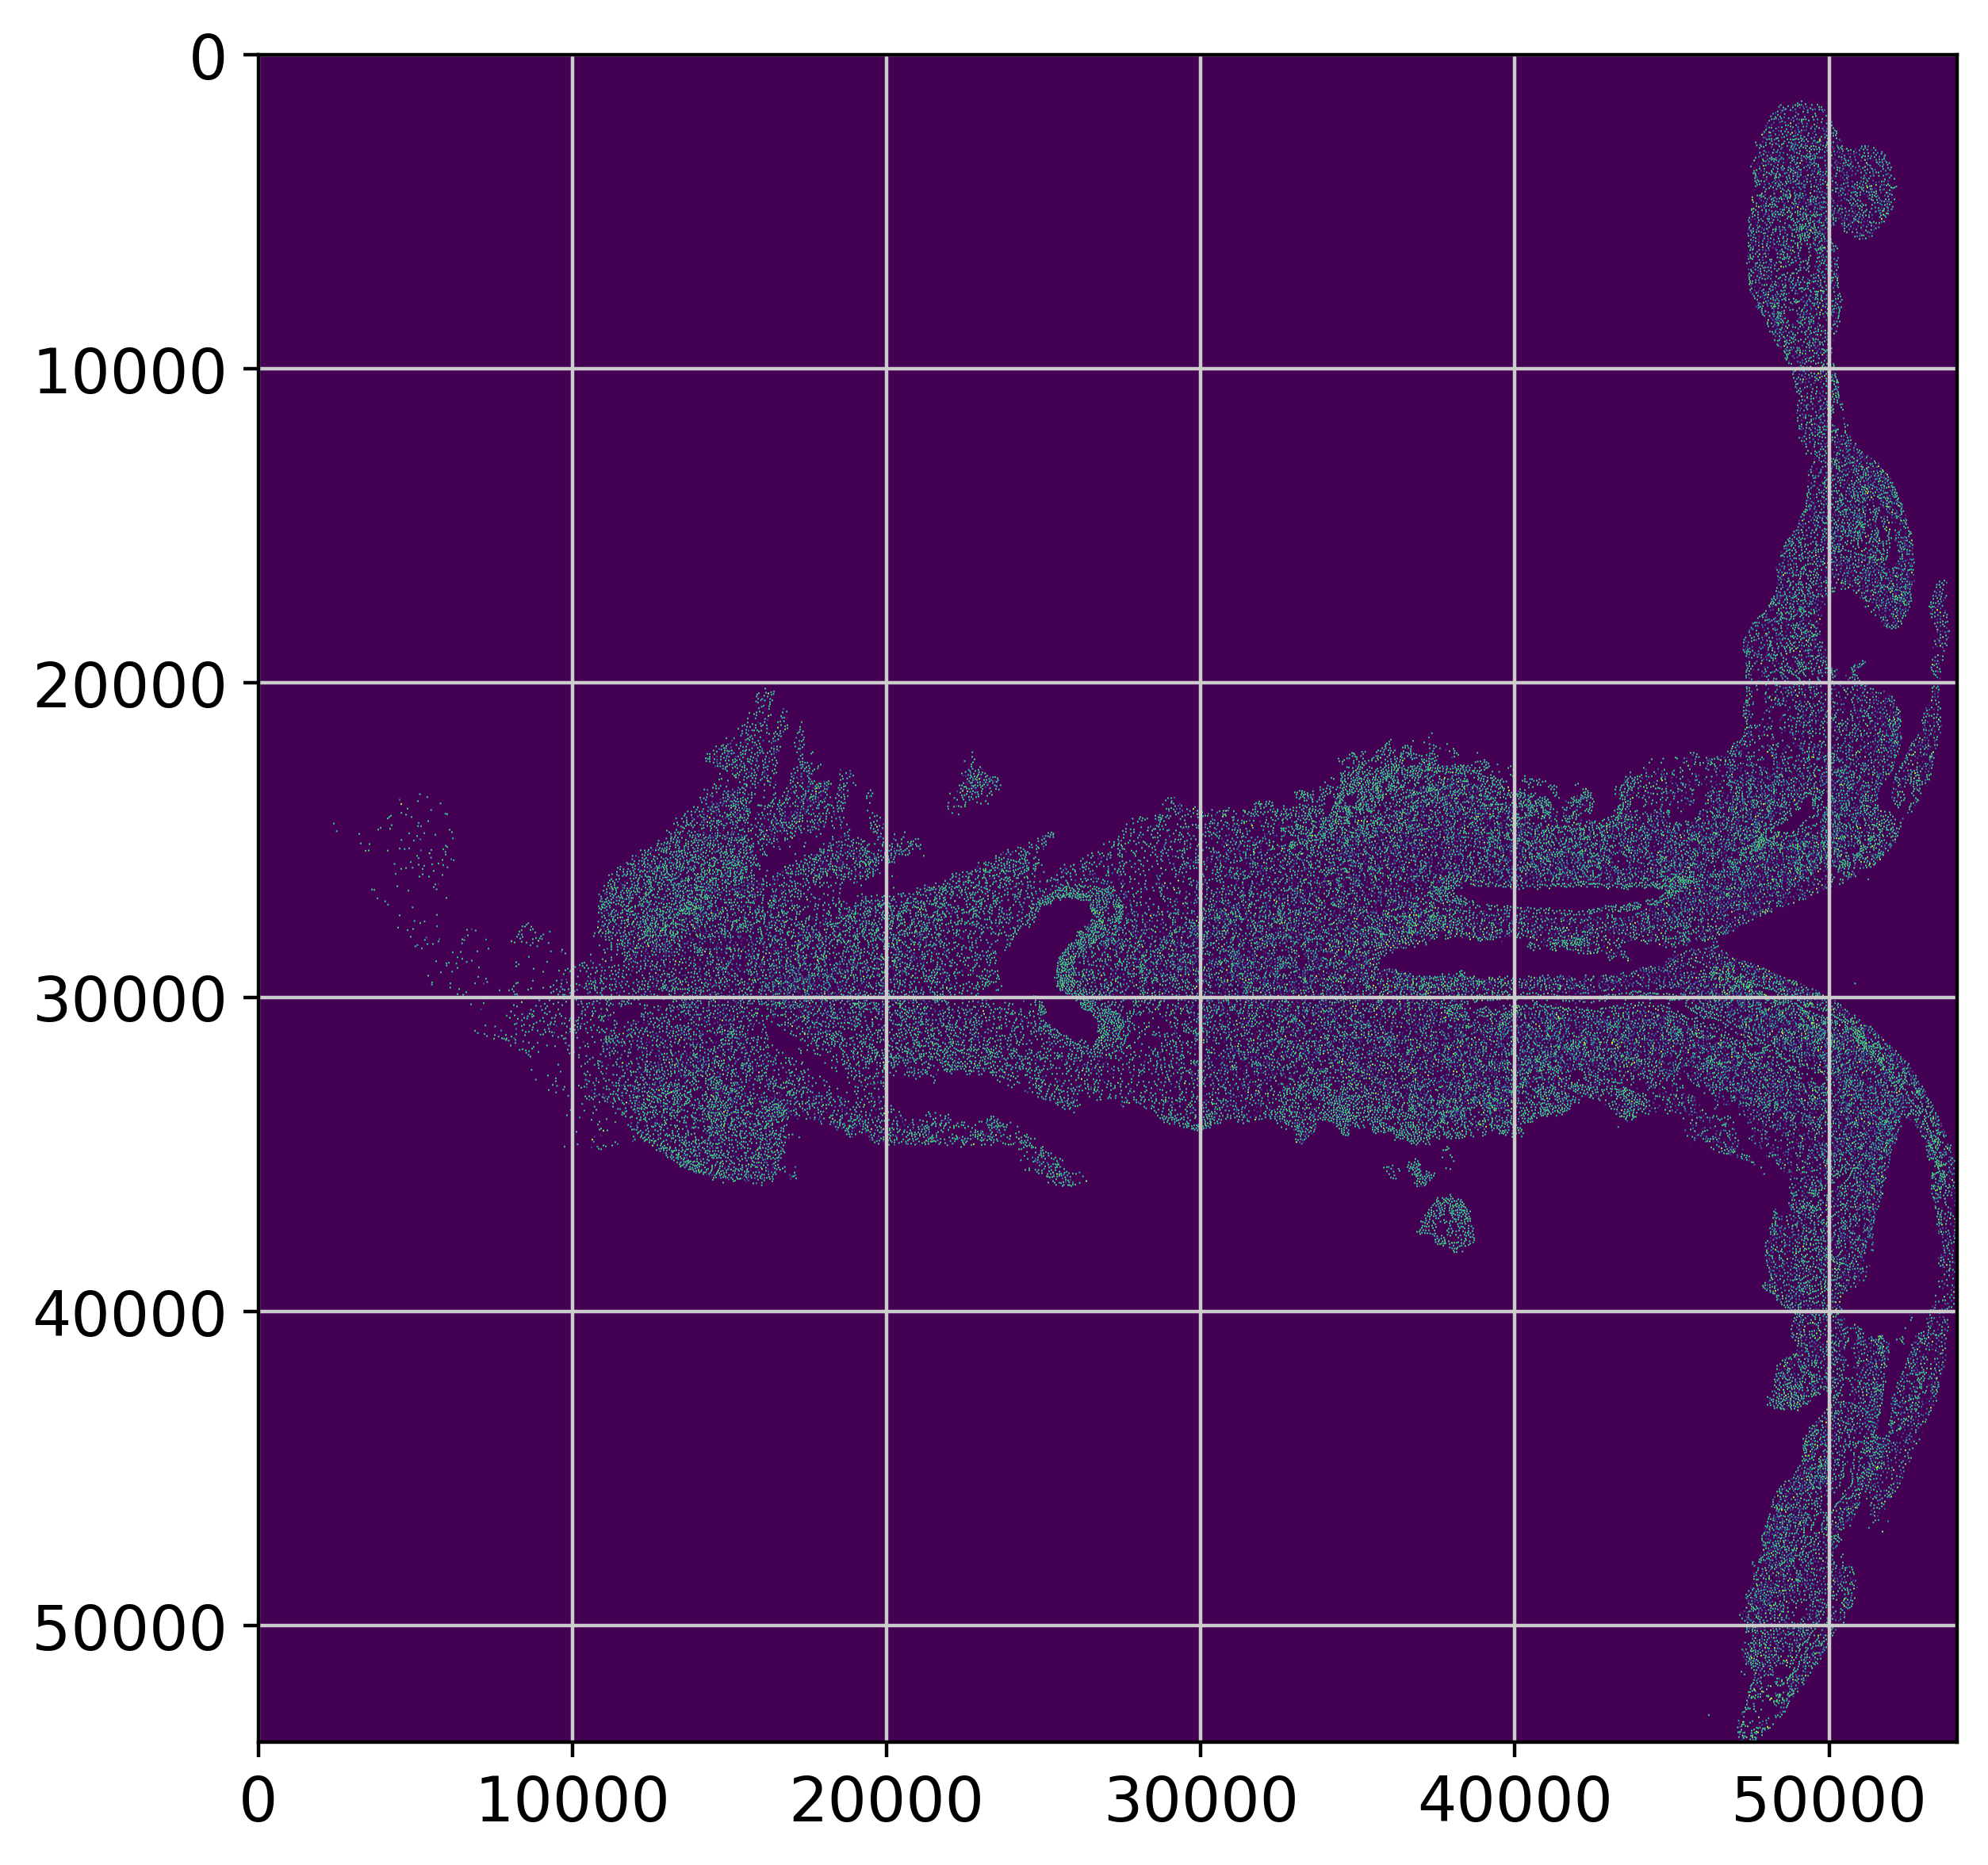

In [25]:
plt.figure(figsize=(7,7), dpi=200)
plt.imshow(ImP,origin='upper')

In [26]:
ImP.save('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM020/CM020_onechannel.png')